# Hyperspace Explorer: LightGBM/Optuna Workflow

This notebook demonstrates a full machine learning workflow for tabular data, including preprocessing (accomodating for class imbalances and categorical data), hyperparameter optimization, model evaluation, and interpretation.

**Workflow overview:**
- Load and preprocess data from Excel (.xlsx)
- Define experiment configuration
- Run hyperparameter search with Optuna and LightGBM
- Analyze and visualize results
- Train and evaluate ensemble models
- Interpret model predictions with SHAP

---

# Stage 0: Import Modules
Import all required external libraries and internal modules for data processing, modeling, and visualization.

---

In [23]:
import os
import sys

# Force CPU only for all following imports and execution
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
sys.path.append(os.path.abspath("../src"))

import optuna
from pathlib import Path
import pandas as pd

from hyperspace_explorer.components.config import Config
from hyperspace_explorer.components.ensemble_study_runner_softvote import EnsembleStudyRunner
from hyperspace_explorer.components.lightgbm_study_runner import LightGBMStudyRunner
from hyperspace_explorer.components.study_utils import (
    suppress_noise,
    set_determinism,
    configure_matplotlib_backend,
    prepare_output_dirs,
    load_dataset,
    create_dataset,
)
from hyperspace_explorer.components.preprocess import (
    validate_features,
    set_categorical,
    create_target,
    report_missing_values,
    split_data,
)
from hyperspace_explorer.components.vizualizations import (
    plot_feature_amount_frequency_loocv,
    plot_feature_selection_frequency_loocv,
    plot_average_roc_curve_loocv,
    plot_average_roc_curve_ensemble,
    plot_shap_summary_loocv,
    plot_shap_summary_ensemble,
    plot_shap_dependence_ensemble,
    plot_shap_feature_importance_ensemble,
    plot_iterations_histogram_loocv,
    visualize_ensemble_results,
    plot_shap_decision_ensemble, plot_class_distribution,
    plot_confusion_matrix_loocv,
    plot_confusion_matrix_ensemble
)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Stage 0: Configuration, Directories, and Data Loading
Load the experiment configuration, set up output directories, and import the dataset. This stage further ensures reproducibility and organizes outputs for later analysis.

---

In [24]:
config = Config(Path(os.path.abspath("../configs/hyperspace_explorer-lgbm-1m-v1-CC_Disability.json")))
suppress_noise()
rng = set_determinism(config.random_seed)
configure_matplotlib_backend(config.plt_backend)
prepare_output_dirs(config)
data = load_dataset(config.file_name)

Loading dataset from ../data/input/raw_new.xlsx...
Data Loaded. Shape: (96, 54)


# Stage 0: Data Preprocessing
Validate and preprocess the dataset:
- Check feature availability
- Define categorical columns
- Create the binary target
- Report missing values
- Split the data into training and holdout sets
- Calculate class imbalance for model weighting

---

In [25]:
# Identify existing features
existing_features = validate_features(data, config.features)
data = set_categorical(data, config.categorical_features)

# Create Binary Target Column
data = create_target(data, config.target_source, config.target)
report_missing_values(data, existing_features)

# Prepare feature and target datasets
all_X = data[existing_features].copy().sort_index(axis=1).reset_index(drop=True)
all_y = data[config.target].copy()

X, holdout_X, y, holdout_y = split_data(all_X, all_y, config.hold_out, config.random_seed)

# Calculate and report class imbalance
class_counts = y.value_counts()
plot_class_distribution(class_counts=class_counts)
config.scale_pos_weight = class_counts.get(0, 0) / class_counts.get(1, 1)
print(f"Calculated scale_pos_weight for LightGBM: {config.scale_pos_weight:.3f}")

⚠️ Column 'pain_mech_neurop' has 4 missing values.
⚠️ Column 'sleep' has 6 missing values.
⚠️ Column 'comorb' has 1 missing values.

Number of records in the training/test set: 63
Number of records in the holdout set: 8

Class distribution in the training/test set:
CC_disability_cluster
1    34
0    29
Name: count, dtype: int64

Class distribution in the holdout set:
CC_disability_cluster
1    4
0    4
Name: count, dtype: int64
Class distribution in training set: {1: 34, 0: 29}
Calculated scale_pos_weight for LightGBM: 0.853


# Stage 1: Hyperspace Exploration
Perform hyperparameter optimization using Optuna and LightGBM with leave-one-out cross-validation (LOOCV). This stage systematically explores the parameter space to identify optimal model settings.

---

In [26]:
loocv_runner = LightGBMStudyRunner(config, X, y)

loocv_runner.create_study()
loocv_runner.explore_hyperspace()
loocv_runner.summarize_results()

/app/MLmodel/src/hyperspace_explorer/components/lightgbm_study_runner.py:45: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  sampler = optuna.samplers.QMCSampler(


  0%|          | 0/10000 [00:00<?, ?it/s]

📈 Number of finished trials: 10000
✅ Number of successful trials: 866


Analyze Hyperspace Exploration Results
Summarize and visualize the results of the hyperparameter search:
- Review model scores and selected features
- Analyze parameter distributions
- Visualize feature selection frequencies and coverage

---

In [27]:
loocv_runner.summarize_scores()
loocv_runner.show_selected_features()
categorical_param_df, numerical_param_df = loocv_runner.analyze_parameters()
feature_stats_df, final_features = loocv_runner.analyze_feature_rankings()


🏅 Top Trials by Objective Scores:


,Trial ID,F1_Score_0,F1_Score_1,ROC_AUC
0,29,0.714286,0.777778,0.746032
1,116,0.714286,0.777778,0.746032
2,132,0.714286,0.777778,0.746032
3,192,0.800000,0.823529,0.682540
4,288,0.714286,0.777778,0.746032
...,...,...,...,...
219,9856,0.714286,0.777778,0.746032
220,9872,0.714286,0.777778,0.746032
221,9908,0.714286,0.777778,0.746032
222,9958,0.714286,0.777778,0.746032



🧠 Selected Features for Top Trials:


,Trial ID,0,1,2,3,4,5,6,7
0,29,sleep,expec,comorb,None,None,None,None,None
1,116,expec,sleep,comorb,gen_health,None,None,None,None
2,132,sleep,expec,bmi,comorb,gen_health,None,None,None
3,192,sleep,bmi,expec,sex,comorb,pain_mech_nocipl,smoke,QoL
4,288,sleep,expec,comorb,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...
219,9856,sleep,expec,comorb,None,None,None,None,None
220,9872,sleep,expec,comorb,None,None,None,None,None
221,9908,sleep,expec,self_eff,comorb,gen_health,None,None,None
222,9958,sleep,expec,comorb,gen_health,None,None,None,None



🔣 Unique Values for Categorical Parameters:


,grow_policy
0,leaf
1,depthwise



📈 Min/Max Range of Numerical Parameters:


,subsample,learning_rate,feature_fraction,max_depth,min_child_weight
min,0.200781,0.195691,0.203223,3,2
max,0.999902,0.999231,0.994043,9,5



📊 Feature Selection Stats Across Trials:


,Feature,Frequency,RankSum,RankSum_Per_Frequency
0,sleep,866,897,1.035797
1,expec,866,1997,2.306005
2,bmi,651,1710,2.626728
3,sex,400,1768,4.420000
4,comorb,760,3443,4.530263
5,gen_health,387,1764,4.558140
6,pain_mech_nocipl,134,746,5.567164
7,QoL,278,1653,5.946043
8,self_eff,24,144,6.000000
9,smoke,41,260,6.341463



📐 RankSum_Per_Frequency Cutoff (coverage=80%): 7

🏁 Final Feature Set (after cutoff):


,Feature,Frequency,RankSum,RankSum_Per_Frequency
0,sleep,866,897,1.035797
1,expec,866,1997,2.306005
2,bmi,651,1710,2.626728
3,sex,400,1768,4.420000
4,comorb,760,3443,4.530263
5,gen_health,387,1764,4.558140
6,pain_mech_nocipl,134,746,5.567164
7,QoL,278,1653,5.946043
8,self_eff,24,144,6.000000
9,smoke,41,260,6.341463


🧠 Final Selected Features: ['sleep', 'expec', 'bmi', 'sex', 'comorb', 'gen_health', 'pain_mech_nocipl', 'QoL', 'self_eff', 'smoke', 'disabil', 'age', 'pain_area']


In [28]:
trial_df_long = (
    pd.DataFrame([
        (trial.number, feat)
        for trial in loocv_runner.study.trials
        if trial.state == optuna.trial.TrialState.COMPLETE
        for feat in trial.user_attrs["selected_features"]
    ], columns=["Trial", "Feature"])
)

frequency_df_sorted, feature_amount_freq, cumulative_percentages, selected_features_coverage_pct = (
    loocv_runner.analyze_feature_frequencies(
        trial_df_long=trial_df_long,
        feat_stats_df=feature_stats_df,
        final_features=final_features
    )
)


📊 Frequency of number of features selected per trial:
3      91
4     241
5     174
6     121
7      98
8      62
9      62
10      8
11      6
12      3
Name: count, dtype: int64

📈 Cumulative % of feature set sizes across trials:
3      10.508083
4      38.337182
5      58.429561
6      72.401848
7      83.718245
8      90.877598
9      98.036952
10     98.960739
11     99.653580
12    100.000000
Name: count, dtype: float64

✅ Coverage of selected features across all feature picks: 100.00%

📋 Top features sorted by frequency and selection status:


,Feature,Frequency,RankSum,RankSum_Per_Frequency,Selected,Cumulative_Frequency,Cumulative_Percentage
0,sleep,866,897,1.035797,True,866,18.543897
1,expec,866,1997,2.306005,True,1732,37.087794
4,comorb,760,3443,4.530263,True,2492,53.361884
2,bmi,651,1710,2.626728,True,3143,67.301927
3,sex,400,1768,4.420000,True,3543,75.867238
5,gen_health,387,1764,4.558140,True,3930,84.154176
7,QoL,278,1653,5.946043,True,4208,90.107066
11,age,202,1378,6.821782,True,4410,94.432548
6,pain_mech_nocipl,134,746,5.567164,True,4544,97.301927
12,pain_area,57,399,7.000000,True,4601,98.522484


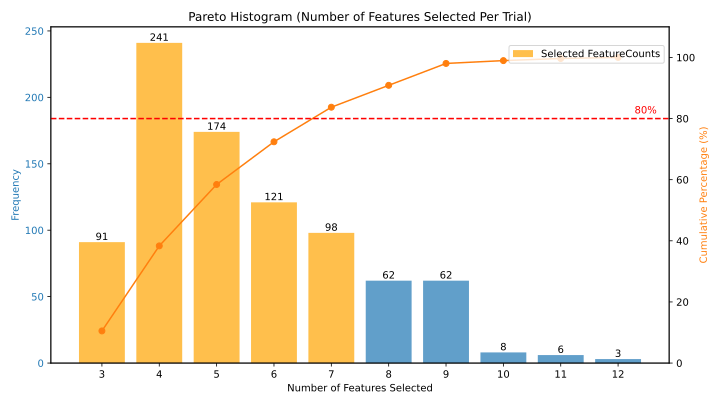

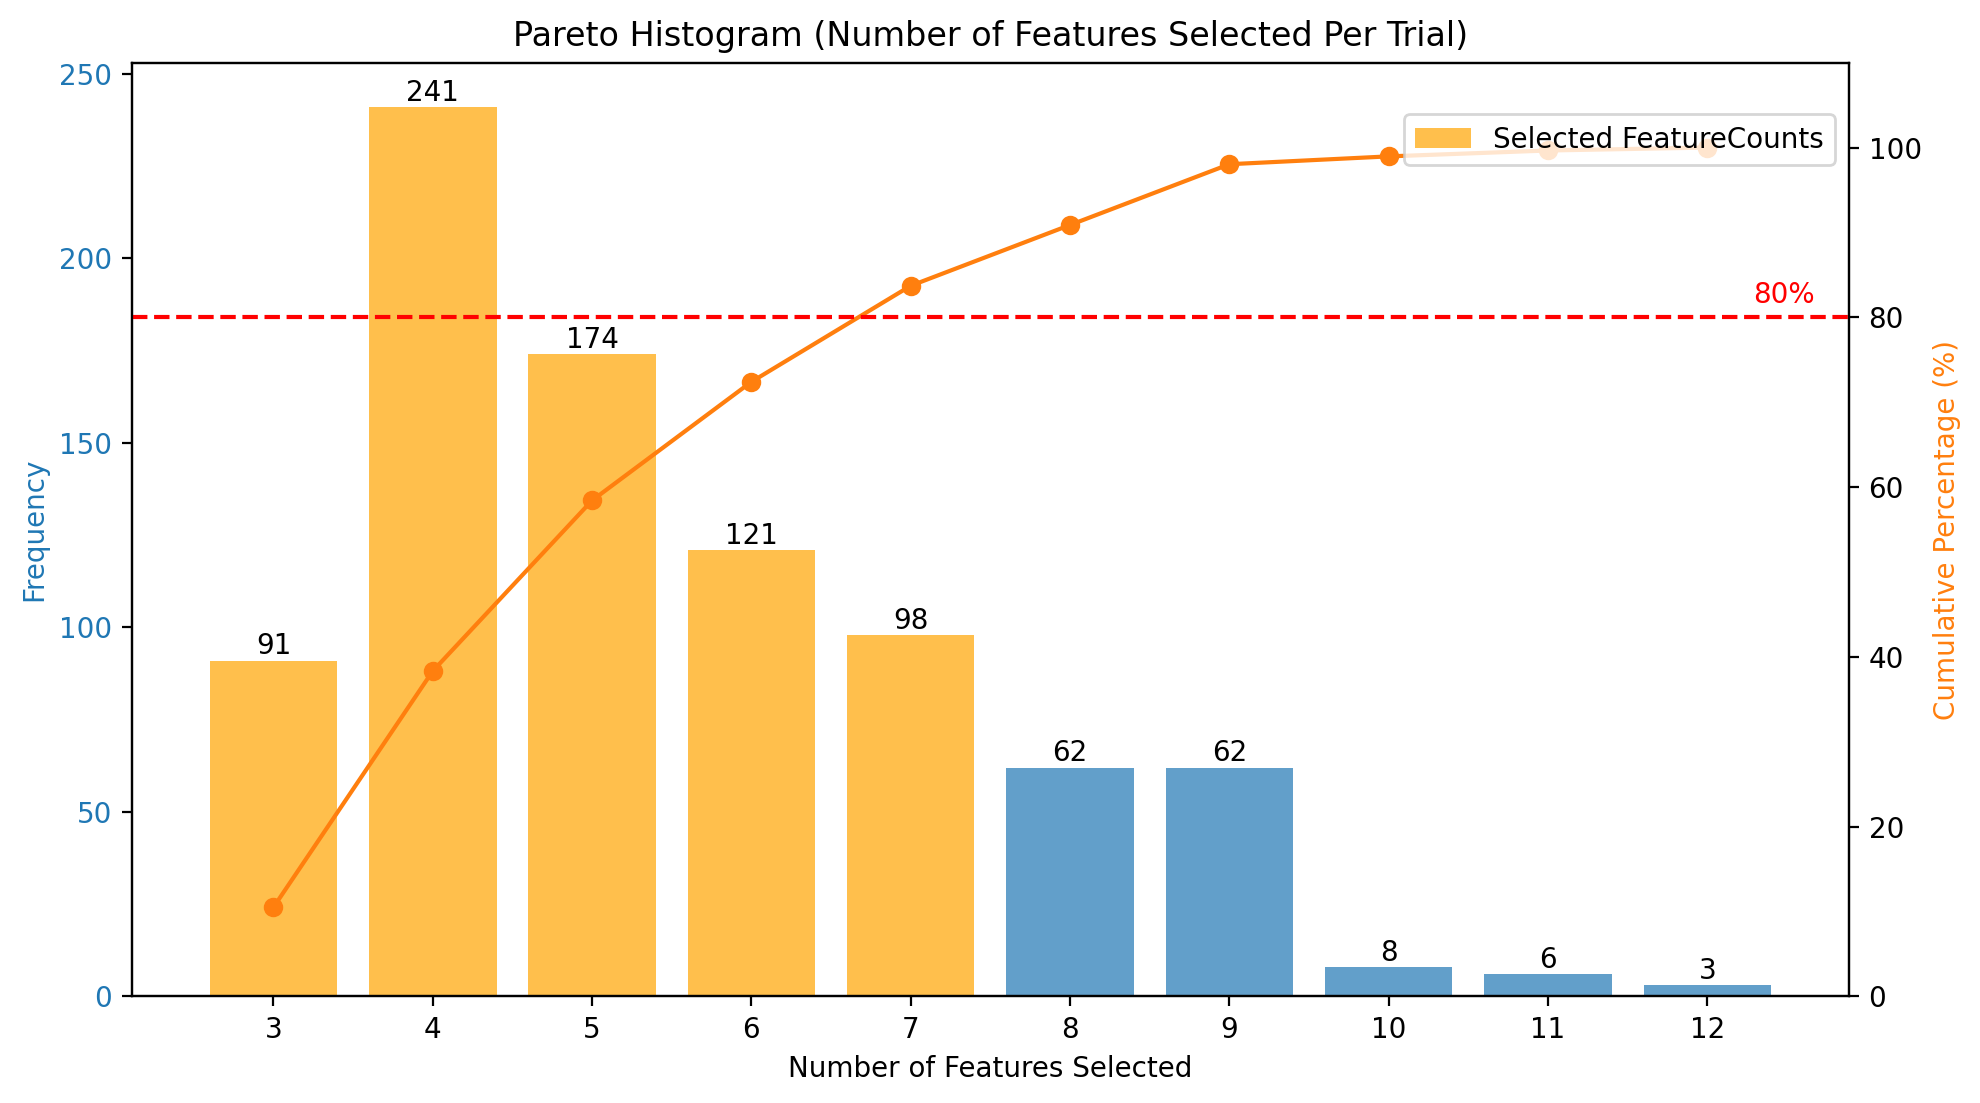

In [29]:
# Visualize feature amount frequency and cumulative percentages
plot_feature_amount_frequency_loocv(
    feature_amount_freq=feature_amount_freq,
    cumulative_percentages=cumulative_percentages,
    x_positions=feature_amount_freq.index,
    config=config,
    threshold_pct=config.feat_count_cov
)
# This plot shows how often different numbers of features are selected across LOOCV trials, and the cumulative percentage. Useful for understanding feature selection stability.

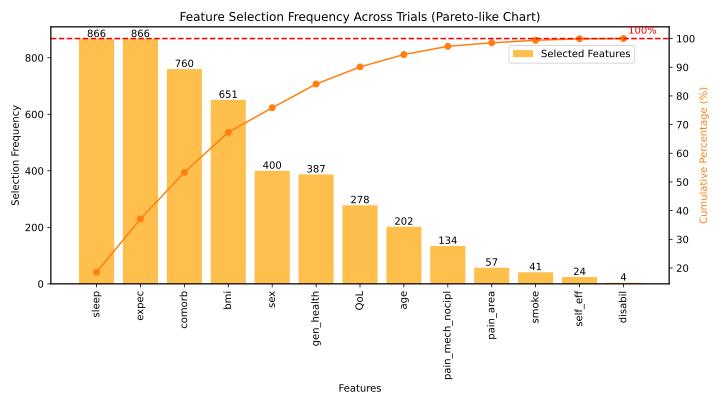

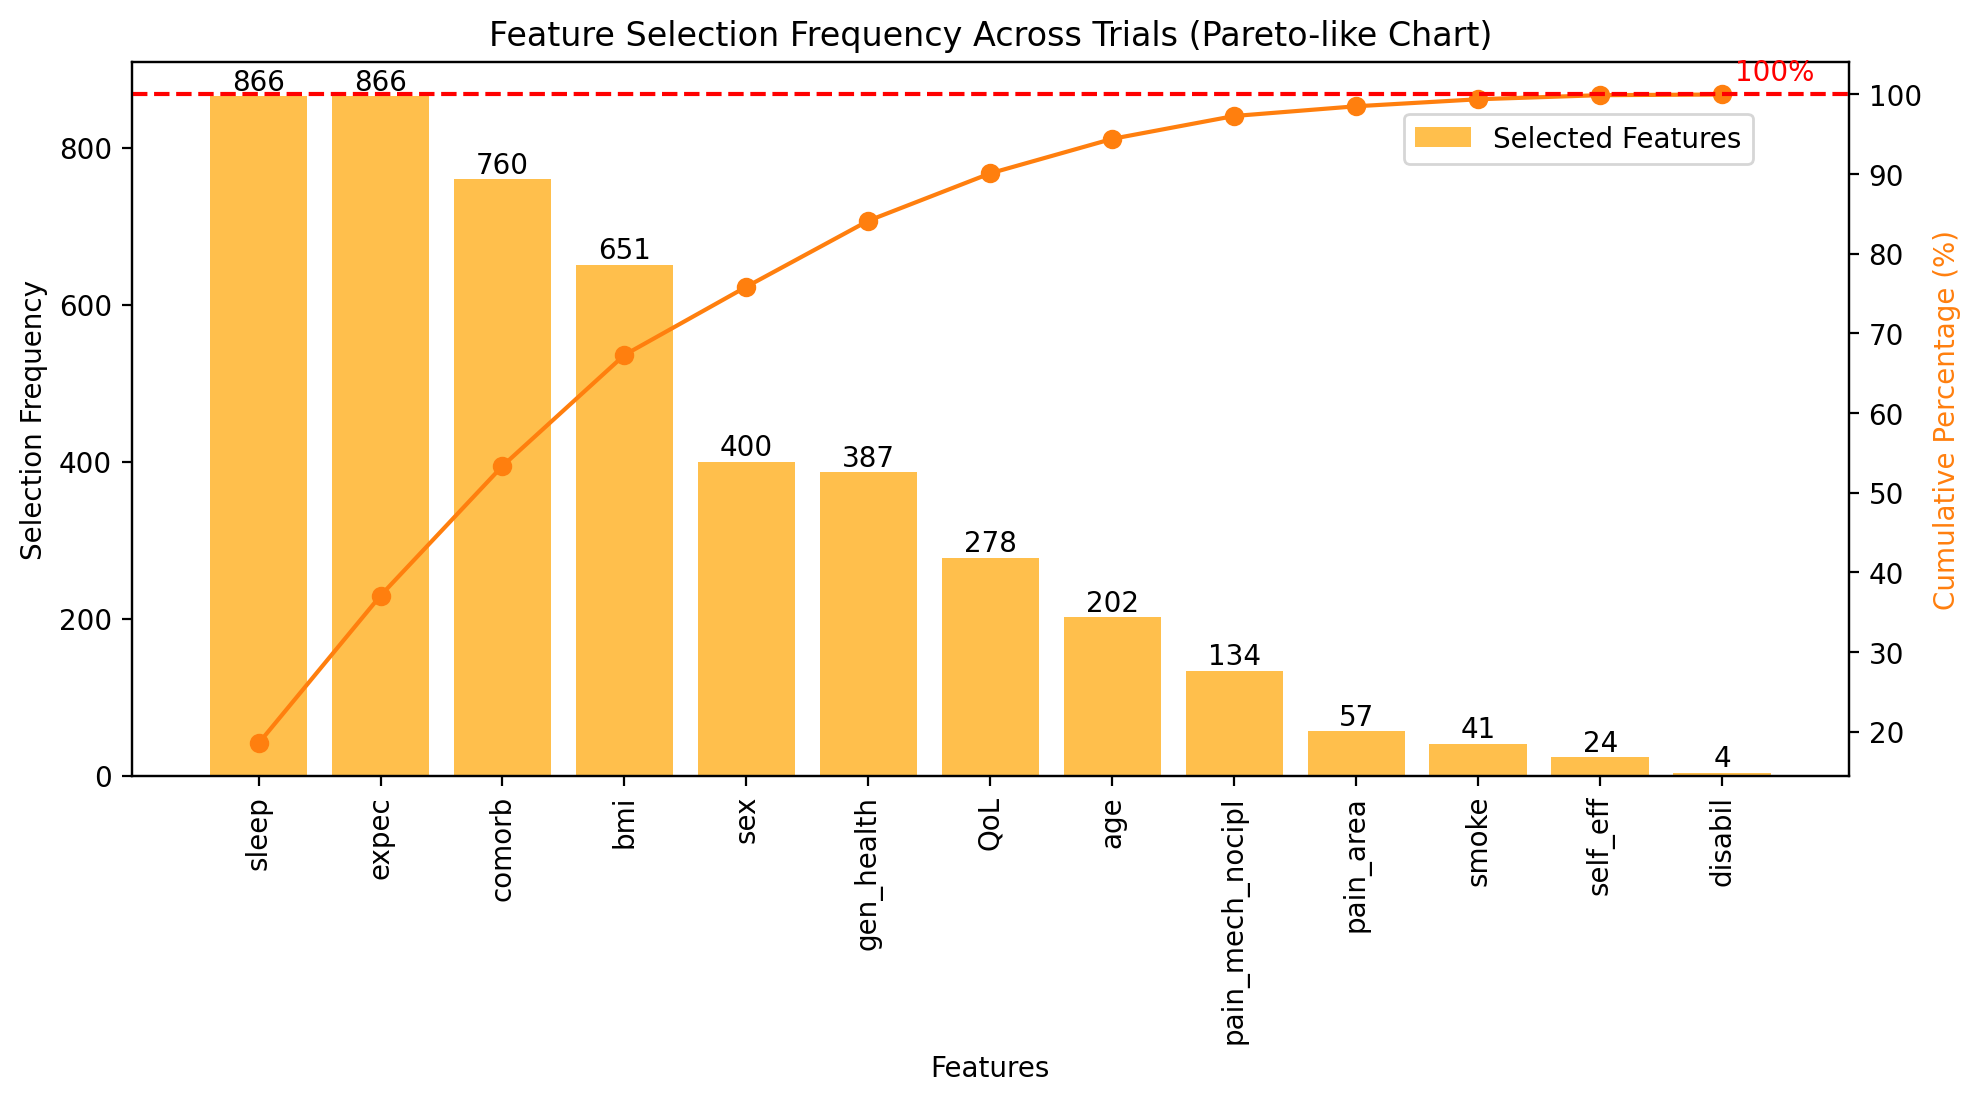

In [30]:
plot_feature_selection_frequency_loocv(
    frequency_df_sorted=frequency_df_sorted,
    selected_features_coverage_pct=selected_features_coverage_pct,
    config=config
)
# This plot shows how frequently each feature was selected across all LOOCV trials, and the overall coverage. It helps identify consistently important features.

## Stage 2: Final LOOCV Study
Conduct a final LOOCV study using the best features and parameters identified. Summarize performance metrics and generate detailed classification reports for robust model evaluation.

---

In [31]:
final_study = loocv_runner.explore_final_hyperspace(
    data=X[final_features],
    target=y,
)

  0%|          | 0/200 [00:00<?, ?it/s]

🧪 Final Study Results
📊 Total trials run: 200
✅ Successful trials: 200


In [32]:
final_scores_df = loocv_runner.get_final_scores_df(final_study)
best_final_params, best_trial = loocv_runner.get_best_final_trial_params(final_study, final_scores_df)

# Print aggregate metrics
loocv_runner.summarize_final_classification_report(final_study, y)

# Print full report across all best predictions
loocv_runner.summarize_combined_report(final_study, y)

📋 Final Best Trials (sorted):


,Trial ID,F1_Score_0,F1_Score_1,ROC_AUC
2,177,0.877193,0.898551,0.943205
0,150,0.885246,0.892308,0.951318
1,172,0.885246,0.892308,0.951318



🏆 Best Final Trial ID: 177
⚙️ Best Final Params:
    verbose: -1
    objective: binary
    n_jobs: 1
    num_threads: 1
    tree_learner: serial
    deterministic: True
    seed: 42
    feature_fraction_seed: 42
    data_random_seed: 42
    max_bin: 255
    metric: binary_logloss
    boosting_type: gbdt
    is_unbalance: False
    scale_pos_weight: 0.8529411764705882
    force_col_wise: True
    subsample: 0.6317810122652119
    learning_rate: 0.9750559710759774
    feature_fraction: 0.20872054228921705
    max_depth: 5
    min_child_weight: 2
    grow_policy: depthwise

📊 Average Classification Report Across Best Trials:
              precision    recall  f1-score   support

           0      0.860     0.908     0.883        29
           1      0.919     0.873     0.894        34
    accuracy                          0.889        63
   macro avg      0.890     0.890     0.888        63
weighted avg      0.892     0.889     0.889        63

📈 Overall Classification Report Across All 

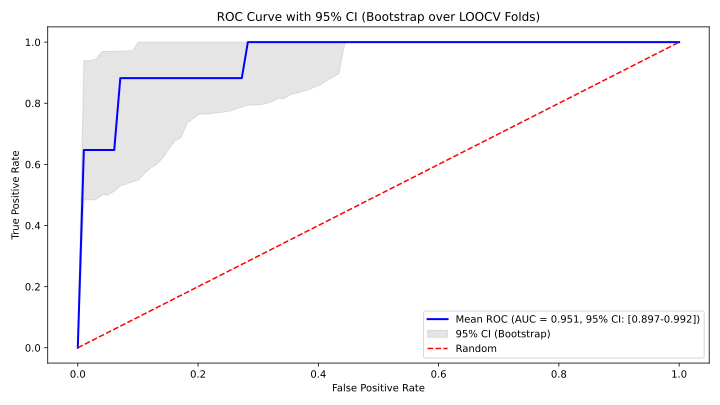

In [33]:
# Visualize average ROC curve for LOOCV
plot_average_roc_curve_loocv(final_study, y, config)

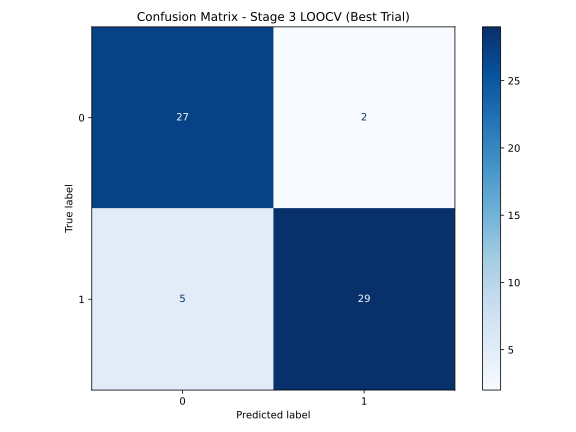

In [34]:
# Visualize confusion matrix for LOOCV
plot_confusion_matrix_loocv(final_study, y, config)

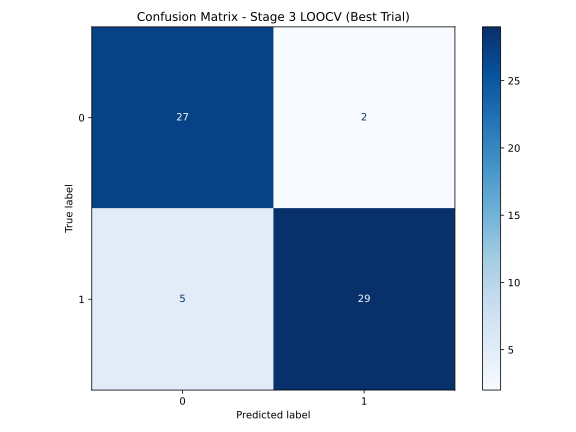

In [35]:
# Visualize confusion matrix for LOOCV
plot_confusion_matrix_loocv(final_study, y, config)

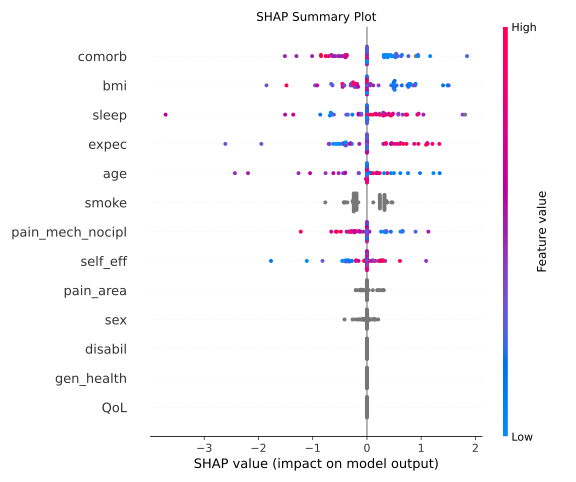

In [36]:
# Visualize SHAP summary for LOOCV
plot_shap_summary_loocv(best_trial, final_features, X, rng, config)

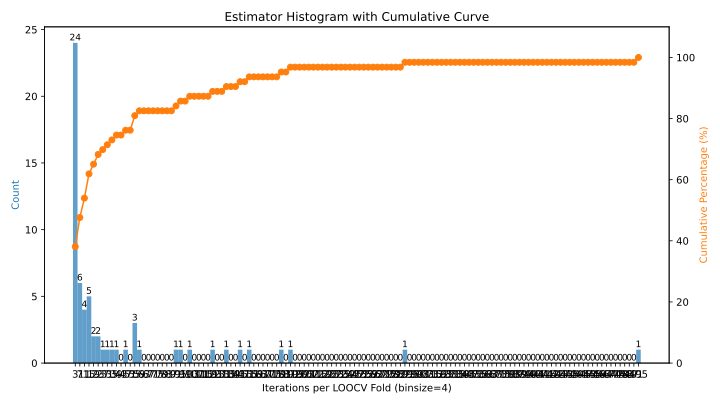

In [37]:
# Visualize iterations histogram for LOOCV
plot_iterations_histogram_loocv(best_trial, config)

# Stage 3: Ensemble Training and Evaluation
Train an ensemble of models using stratified k-fold cross-validation. Aggregate predictions via majority voting on the holdout set, and visualize ensemble performance and feature importance for comprehensive assessment.

---

In [38]:
ensemble_runner = EnsembleStudyRunner(config=config,
                                      numerical_param_df=numerical_param_df,
                                      categorical_param_df=categorical_param_df)

ensemble_result = ensemble_runner.run_final_study(X, y, final_features)

  0%|          | 0/200 [00:00<?, ?it/s]

Number of finished trials:  200


,Trial ID,F1_Score_0,F1_Score_1,ROC_AUC
11,86,0.357692,0.704242,0.617222
31,157,0.357692,0.704242,0.617222
18,119,0.337179,0.692121,0.636746
37,170,0.337179,0.692121,0.636746
2,32,0.419394,0.636111,0.564841
44,194,0.419394,0.636111,0.564841
4,51,0.439394,0.627619,0.569286
7,70,0.444351,0.603102,0.537540
27,146,0.444351,0.603102,0.537540
28,150,0.361905,0.600000,0.625635


Best Trial ID: 86
  Final Features: ['sleep', 'expec', 'bmi', 'sex', 'comorb', 'gen_health', 'pain_mech_nocipl', 'QoL', 'self_eff', 'smoke', 'disabil', 'age', 'pain_area']
  Params:
    verbose: -1
    objective: binary
    n_jobs: 1
    num_threads: 1
    tree_learner: serial
    deterministic: True
    seed: 42
    feature_fraction_seed: 42
    data_random_seed: 42
    max_bin: 255
    metric: binary_logloss
    boosting_type: gbdt
    is_unbalance: False
    scale_pos_weight: 0.8529411764705882
    force_col_wise: True
    subsample: 0.846788623011426
    learning_rate: 0.2330156844202462
    feature_fraction: 0.28046374797106416
    max_depth: 7
    min_child_weight: 3
    grow_policy: depthwise
Estimators:  [1, 1, 2, 8, 13]

Average Classification Report Across Folds:
              precision    recall  f1-score   support
           0      0.613     0.400     0.358         6
           1      0.684     0.819     0.704         7

    accuracy                          0.623        13

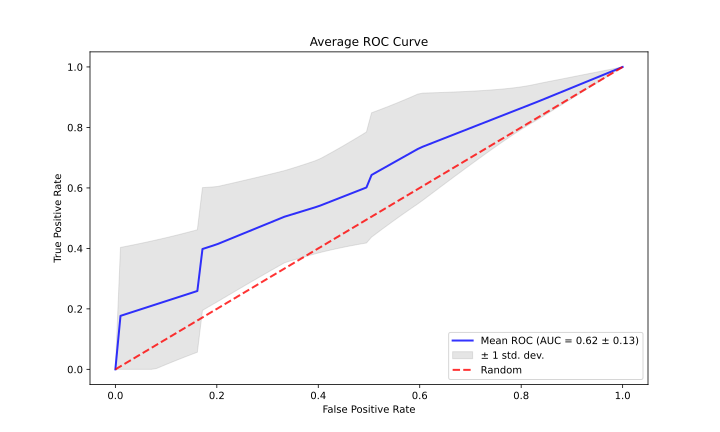

In [39]:
# Visualize average ROC curve for ensemble
plot_average_roc_curve_ensemble(ensemble_result["best_trial"], config)
# This plot shows the average ROC curve for the ensemble model, summarizing its discrimination performance across folds.

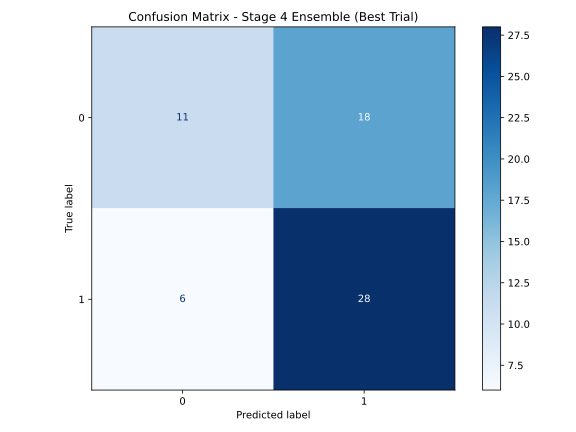

In [40]:
# Visualize confusion matrix for ensemble
plot_confusion_matrix_ensemble(ensemble_result["best_trial"], config)

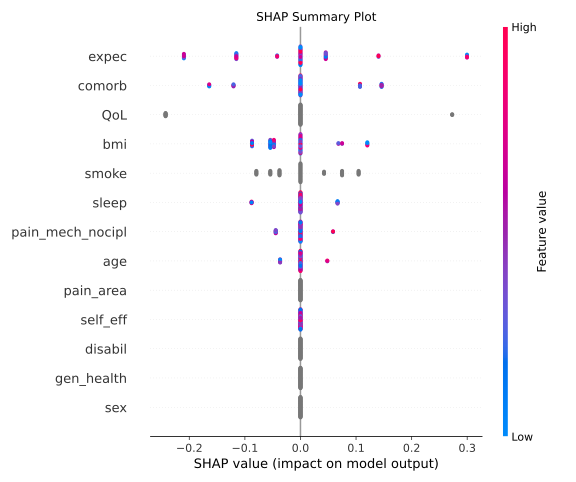

In [41]:
# Visualize SHAP summary for ensemble best trial
plot_shap_summary_ensemble(ensemble_result["best_trial"], X[final_features], final_features, config, rng)
# This plot provides a global view of feature importance and the direction of their effects for the ensemble model.

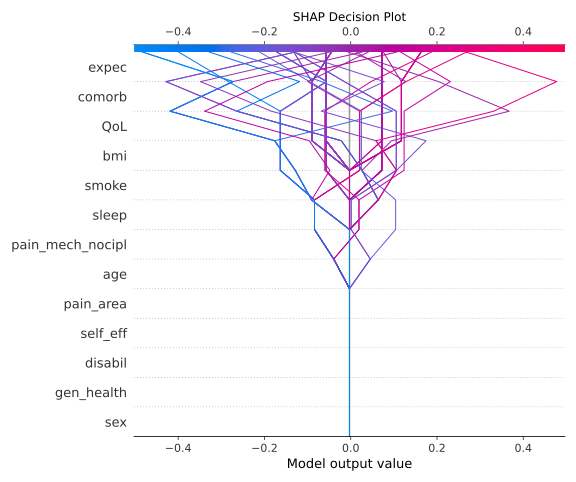

In [42]:
# Visualize SHAP decision plot for ensemble best trial
plot_shap_decision_ensemble(ensemble_result["best_trial"], X[final_features], final_features, config)
# This plot shows how individual features contribute to the model's decision for each sample in the ensemble, helping to interpret model predictions.

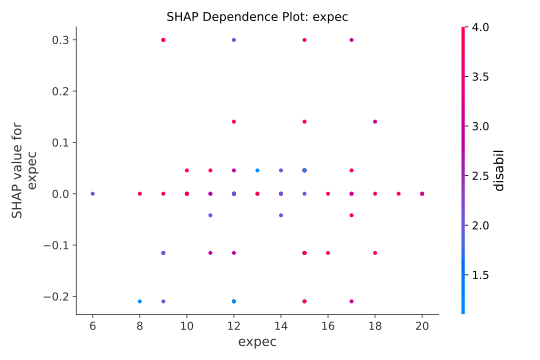

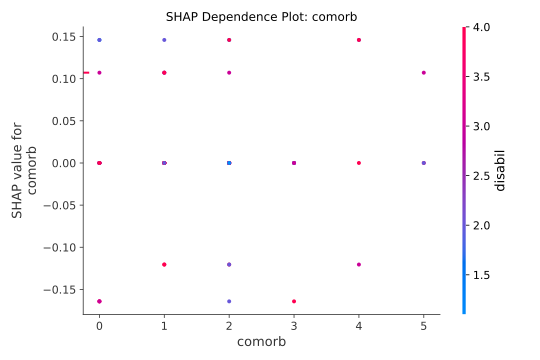

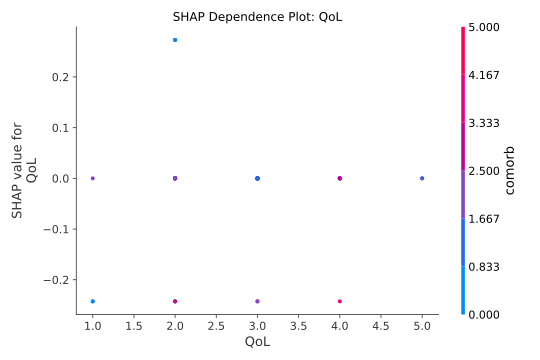

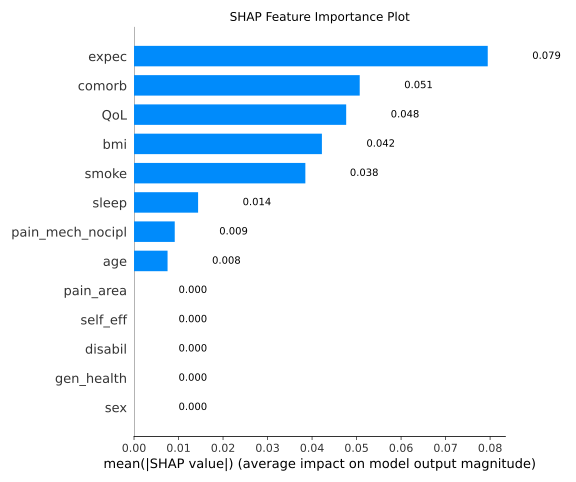

In [43]:
plot_shap_dependence_ensemble(ensemble_result["best_trial"], X[final_features], final_features, config, max_features=3)
plot_shap_feature_importance_ensemble(ensemble_result["best_trial"], X[final_features], final_features, config, rng)

  0%|          | 0/8 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.67      0.50      0.57         4
           1       0.60      0.75      0.67         4

    accuracy                           0.62         8
   macro avg       0.63      0.62      0.62         8
weighted avg       0.63      0.62      0.62         8



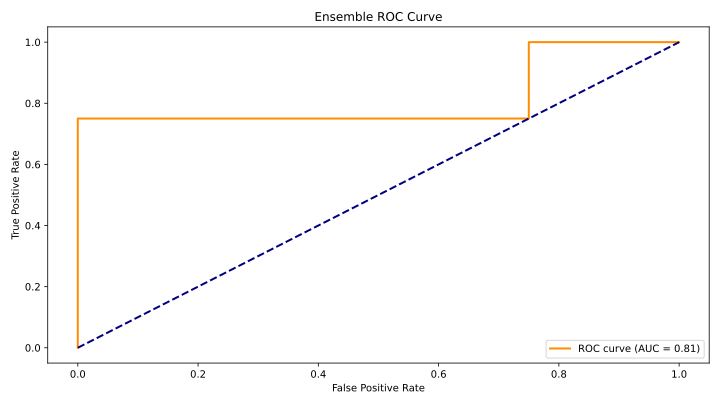

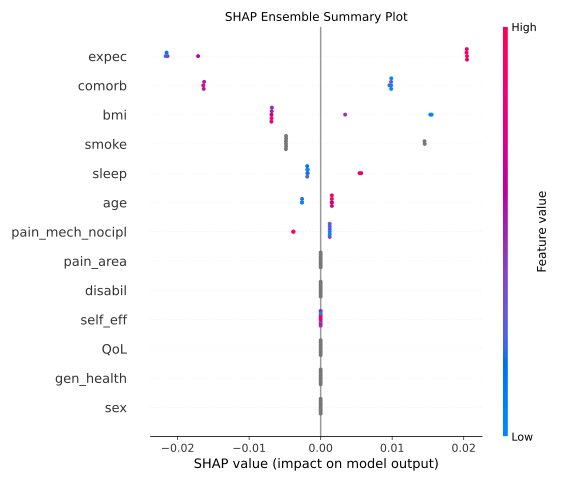

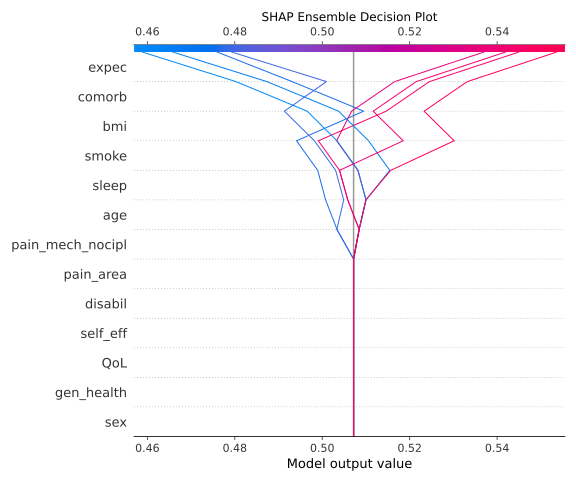

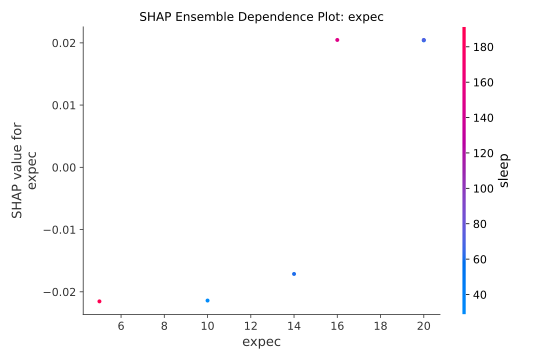

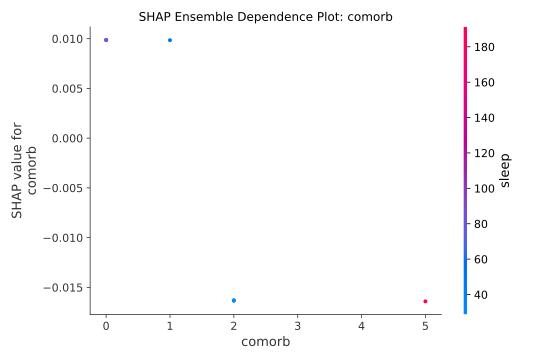

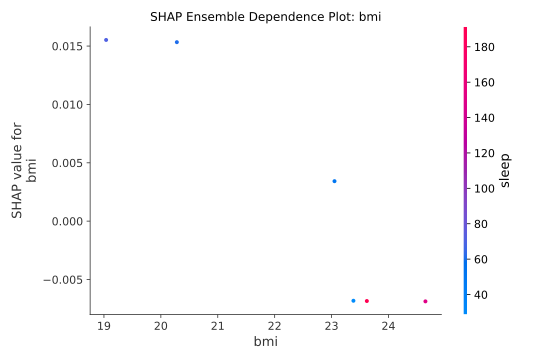

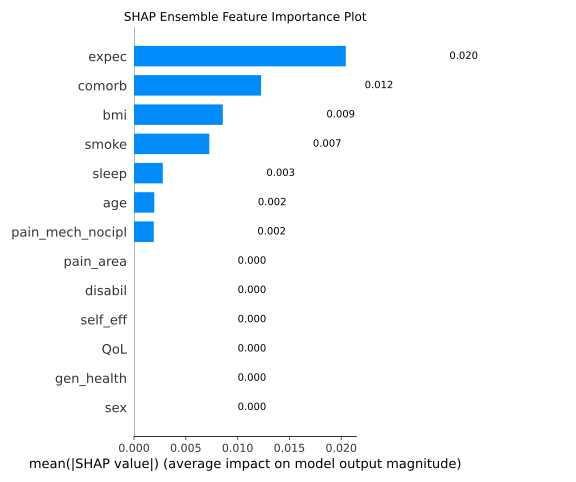

In [44]:
results = ensemble_runner.evaluate_ensemble(
    best_trial=ensemble_result["best_trial"],
    holdout_X=holdout_X,
    holdout_y=holdout_y,
    final_features=final_features,
    create_dataset=create_dataset
)

print(results["report"])  # Optional: check classification report

visualize_ensemble_results(results, final_features, config, rng)